In [1]:
import tensorflow as tf
from makiflow.models.classificator import Classificator
from makiflow.metrics import bin_categorical_dice_coeff
from sklearn.metrics import confusion_matrix, f1_score, classification_report
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import pandas as pd
import json
from tqdm import tqdm
%matplotlib inline

from makiflow import set_main_gpu
set_main_gpu(';')

In [2]:
from makiflow.metrics.utils import one_hot

In [3]:
N_CLASSES = 8
IMAGE_SHAPE = (1024, 1024)

In [4]:
SESSION = tf.Session()

In [10]:
def create_model(arch_path, weights_path):
    model = Classificator.from_json(arch_path)
    model.set_session(SESSION)
    model.load_weights(weights_path)
    return model

def load_im_mask(image_path, masks_folder_path):
    image_shape = IMAGE_SHAPE
    n_classes = N_CLASSES
    image = cv2.imread(image_path)

    mask_folder = masks_folder_path

    label_tensor = np.zeros(shape=(*image_shape, n_classes + 1), dtype='int32')
    for binary_mask_path in glob(os.path.join(mask_folder, '*')):
        filename = binary_mask_path.split('/')[-1]
        class_id = int(filename.split('.')[0])
        assert class_id != 0, 'Encountered class 0. Class names must start from 1.'
        binary_mask = cv2.imread(binary_mask_path)
        assert binary_mask is not None, f'Could not load mask with name={binary_mask_path}'
        label_tensor[..., class_id] = binary_mask[..., 0] * class_id
    label_tensor = np.max(label_tensor, axis=-1)
    
    return image.astype(np.float32, copy=False) / 255, label_tensor

def load_data(config_path):
    config = load_json(config_path)
    config = config['test_config']
    image_paths = config['test_image']
    mask_paths = config['test_mask']
    
    images = []
    masks = []
    for image_path, mask_folder_path in zip(image_paths, mask_paths):
        image, mask = load_im_mask(image_path, mask_folder_path)
        images.append(image)
        masks.append(mask)
    return images, masks

def load_json(path):
    with open(path, 'r') as f:
        return json.loads(f.read())

def test(arch_path, weights_path, config_path, th=0.5):
    images, masks = load_data(config_path)
    model = create_model(arch_path, weights_path)
    
    predictions = []
    max_preds = []
    for image in tqdm(images):
        pred = (model.predict([image])[0] > th).astype('uint8') * np.arange(1, 9, 1).reshape(1, 1, 8)
#         pred = pred.max(axis=-1)
        predictions += [pred]
        max_preds += [pred.max(axis=-1)]
    
    # predictions = np.concatenate(predictions, axis=0)
    max_preds = np.array(max_preds).ravel()
    masks = np.array(masks).ravel()
    return classification_report(masks, max_preds, output_dict=True)


def compute_tpr_tnr_class(class_id, C):
    TN = C[0, 0]
    TP = C[class_id, class_id]
    
    FP = 0
    for i in range(0, C.shape[0]):
        if i == class_id:
            continue
        FP += C[i, class_id]
        
    FN = 0
    for i in range(0, C.shape[0]):
        if i == class_id:
            continue
        FN += C[class_id, i]
    
    tpr = 1 - FN / (FN + TP + 1e-7)
    tnr = 1 - FP / (FP + TN + 1e-7)
    acc = (TP + TN) / (TP + TN + FP + FN)
    return tpr, tnr, acc
    
def compute_tpr(C):
    trps = []
    tnrs = []
    accs = []
    for i in range(1, C.shape[0]):
        rates = compute_tpr_tnr_class(i, C)
        trps.append(rates[0])
        tnrs.append(rates[1])
        accs.append(rates[2])
    return trps, tnrs, accs

In [11]:
# networks = ['densenet', 'resnet', 'xception']
# folds_folders = ['cv3_fold0', 'cv3_fold1', 'cv3_fold2']
networks = ['preprocess_xception']
folds_folders = ['cv3_fold2']
path_model_arch = 'result/model.json'
path_model_weights = 'result/last_weights/weights.ckpt'
path_config = 'config.json'

experminet_results = []
for network in networks:
    nn_res = {}
    for fold in folds_folders:
        try:
            scores = test(os.path.join(network, fold, path_model_arch), os.path.join(network, fold, path_model_weights), os.path.join(network, fold, path_config), 0.5)
        except Exception as e:
            print(e)
            another_folder = 'result_1/epoch_11/weights.ckpt'
            scores = test(os.path.join(network, fold, path_model_arch), os.path.join(network, fold, another_folder), os.path.join(network, fold, path_config), 0.5)
        if len(nn_res) == 0:
            nn_res = scores
        else:
            for key, values in scores.items():
                try:
                    if key == 'accuracy':
                        nn_res[key] += scores[key]
                    else:
                        nn_res[key] = {in_key: in_values + nn_res[key][in_key] for in_key, in_values in values.items()}
                except Exception as e:
                    print(e)
                    print(key, values, nn_res)
    experminet_results.append(nn_res)

Model is restored!
The passed save_path is not a valid checkpoint: preprocess_xception/cv3_fold2/result/last_weights/weights.ckpt
Model is restored!
INFO:tensorflow:Restoring parameters from preprocess_xception/cv3_fold2/result_1/epoch_11/weights.ckpt


  0%|          | 0/8 [00:00<?, ?it/s]
0it [00:00, ?it/s]

Weights are loaded.



1it [00:04,  4.61s/it]
 12%|█▎        | 1/8 [00:04<00:33,  4.72s/it]
0it [00:00, ?it/s]
1it [00:02,  2.77s/it]
 25%|██▌       | 2/8 [00:07<00:25,  4.17s/it]
0it [00:00, ?it/s]
1it [00:02,  2.76s/it]
 38%|███▊      | 3/8 [00:10<00:18,  3.78s/it]
0it [00:00, ?it/s]
1it [00:02,  2.76s/it]
 50%|█████     | 4/8 [00:13<00:14,  3.51s/it]
0it [00:00, ?it/s]
1it [00:02,  2.86s/it]
 62%|██████▎   | 5/8 [00:16<00:10,  3.35s/it]
0it [00:00, ?it/s]
1it [00:02,  2.78s/it]
 75%|███████▌  | 6/8 [00:19<00:06,  3.21s/it]
0it [00:00, ?it/s]
1it [00:02,  2.82s/it]
 88%|████████▊ | 7/8 [00:22<00:03,  3.13s/it]
0it [00:00, ?it/s]
1it [00:02,  2.75s/it]
100%|██████████| 8/8 [00:24<00:00,  3.12s/it]


In [41]:
experminet_results[0]['0']['precision'] / 3

0.9775217411279858

In [13]:
for nn, nn_name in zip(experminet_results, networks):
    df = pd.DataFrame(data=nn)
#     df = df.div(3, axis=1)
    df = df.round(2)
    df.to_excel(f'without_norm_{nn_name}.xlsx')

In [128]:
network = 'xception'
fold = 'cv3_fold1'
path_model_arch = 'result/model.json'
path_model_weights = 'result/epoch_11/weights.ckpt'
path_config = 'config.json'

In [189]:
def test_ret_images(arch_path, weights_path, config_path, th=0.7):
    images, masks = load_data(config_path)
    model = create_model(arch_path, weights_path)
    
    results = []
    max_preds = []
    for image in tqdm(images):
        pred = model.predict([image])[0]
        result = np.zeros(pred.shape, dtype=np.bool)
        result = pred > 0.5 
        result[::, ::, 2] = pred[::, ::, 2] > 0.8 
        result = result.astype('uint8') * np.arange(1, 9, 1).reshape(1, 1, 8)
        max_preds += [result.max(axis=-1)]
        results.append(result)
    
    return max_preds, results

In [190]:
predictions, results = test_ret_images(os.path.join(network, fold, path_model_arch), os.path.join(network, fold, path_model_weights), os.path.join(network, fold, path_config), 0.7)

Model is restored!
INFO:tensorflow:Restoring parameters from xception/cv3_fold1/result/epoch_11/weights.ckpt






  0%|          | 0/8 [00:00<?, ?it/s]




0it [00:00, ?it/s]

Weights are loaded.







1it [00:14, 14.03s/it]




 12%|█▎        | 1/8 [00:14<01:39, 14.15s/it]




0it [00:00, ?it/s]




1it [00:02,  2.95s/it]




 25%|██▌       | 2/8 [00:17<01:04, 10.82s/it]




0it [00:00, ?it/s]




1it [00:02,  2.96s/it]




 38%|███▊      | 3/8 [00:20<00:42,  8.50s/it]




0it [00:00, ?it/s]




1it [00:02,  2.94s/it]




 50%|█████     | 4/8 [00:23<00:27,  6.87s/it]




0it [00:00, ?it/s]




1it [00:03,  3.01s/it]




 62%|██████▎   | 5/8 [00:26<00:17,  5.74s/it]




0it [00:00, ?it/s]




1it [00:03,  3.10s/it]




 75%|███████▌  | 6/8 [00:29<00:09,  4.99s/it]




0it [00:00, ?it/s]




1it [00:02,  2.98s/it]




 88%|████████▊ | 7/8 [00:32<00:04,  4.42s/it]




0it [00:00, ?it/s]




1it [00:02,  2.98s/it]




100%|██████████| 8/8 [00:35<00:00,  4.49s/it]


In [355]:
pred = results[0]

In [178]:
result = pred > 0.5 
result[::, ::, 3] = pred[::, ::, 3] > 0.9 
result = result.astype('uint8') * np.arange(1, 9, 1).reshape(1, 1, 8)
# result = result.max(axis=-1)

In [191]:
predictions = np.array(predictions)

In [192]:
import seaborn as sns

In [193]:
images, masks = load_data(os.path.join(network, fold, path_config))

In [295]:
cmap = sns.mpl_palette("CMRmap", 8)
yticklabels = ['Фон', 'OD', 'M', 'BV', 'HE', 'SE', 'NC', 'PC', 'H']

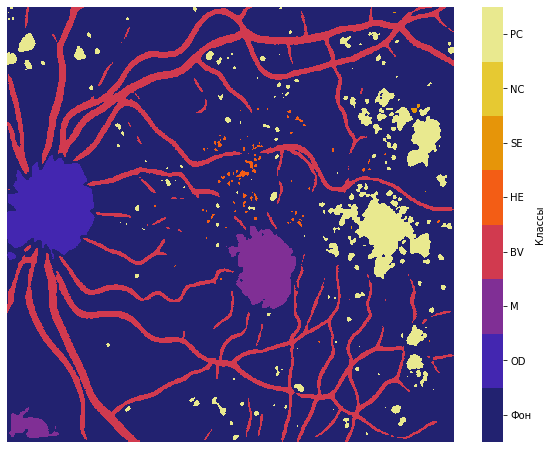

In [296]:
fig, ax1, ax2, ax3 = plt.subplots(1, 3, figsize=(10, 8))
ax = sns.heatmap(predictions[0], cmap=cmap, cbar_kws={'label': 'Классы'}, xticklabels=False, yticklabels=False)
cbar = ax.collections[0].colorbar
cbar.set_ticks(np.arange(0, 8) + 0.5)
cbar.set_ticklabels(yticklabels)

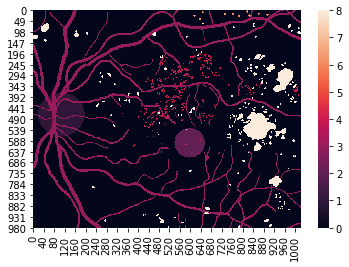

In [195]:
sns.heatmap(masks[0])

In [323]:
import matplotlib 
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

Plotting 0 image


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


Plotting 1 image
Plotting 2 image
Plotting 3 image
Plotting 4 image
Plotting 5 image
Plotting 6 image
Plotting 7 image


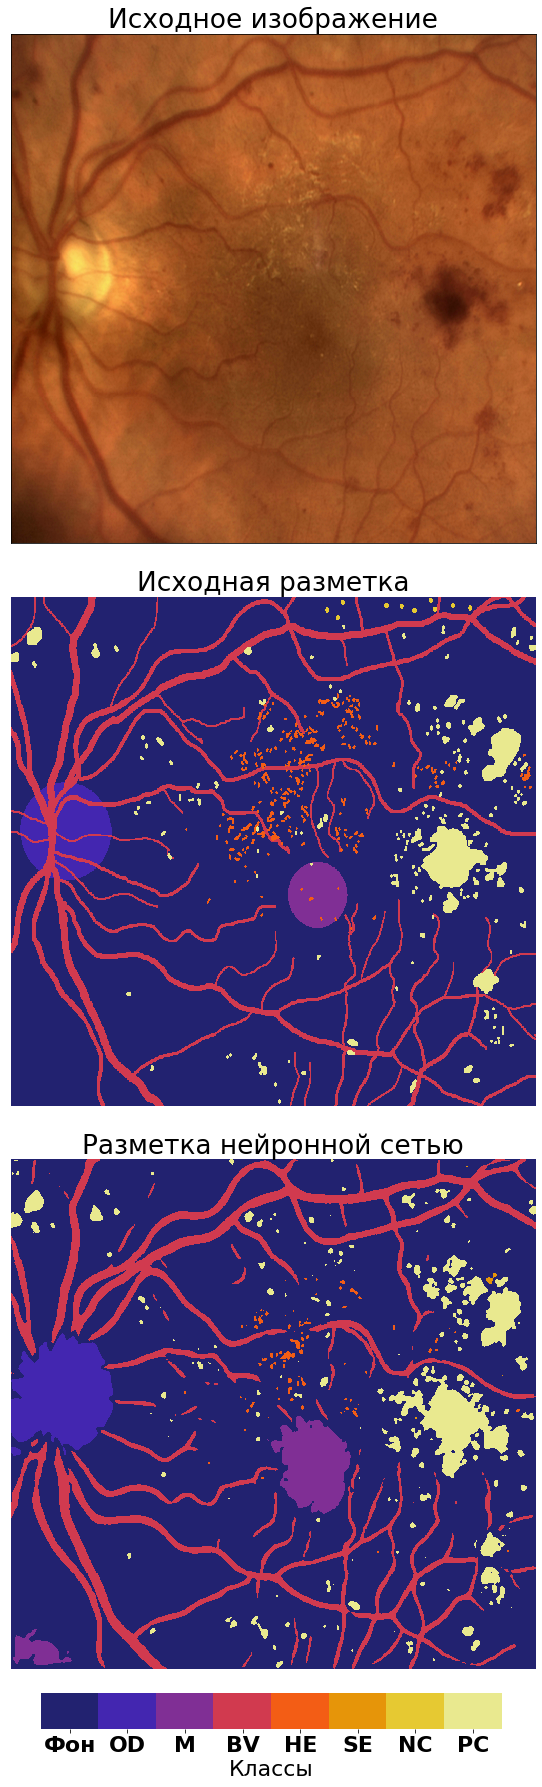

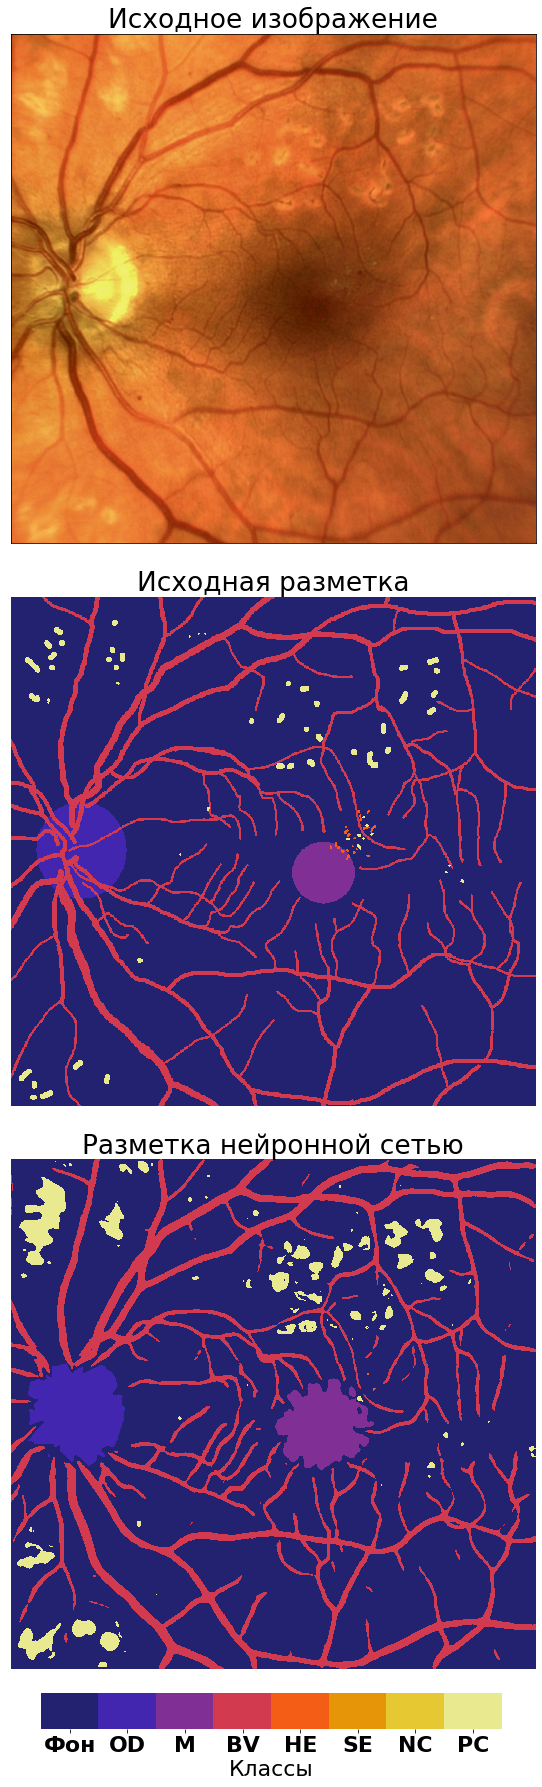

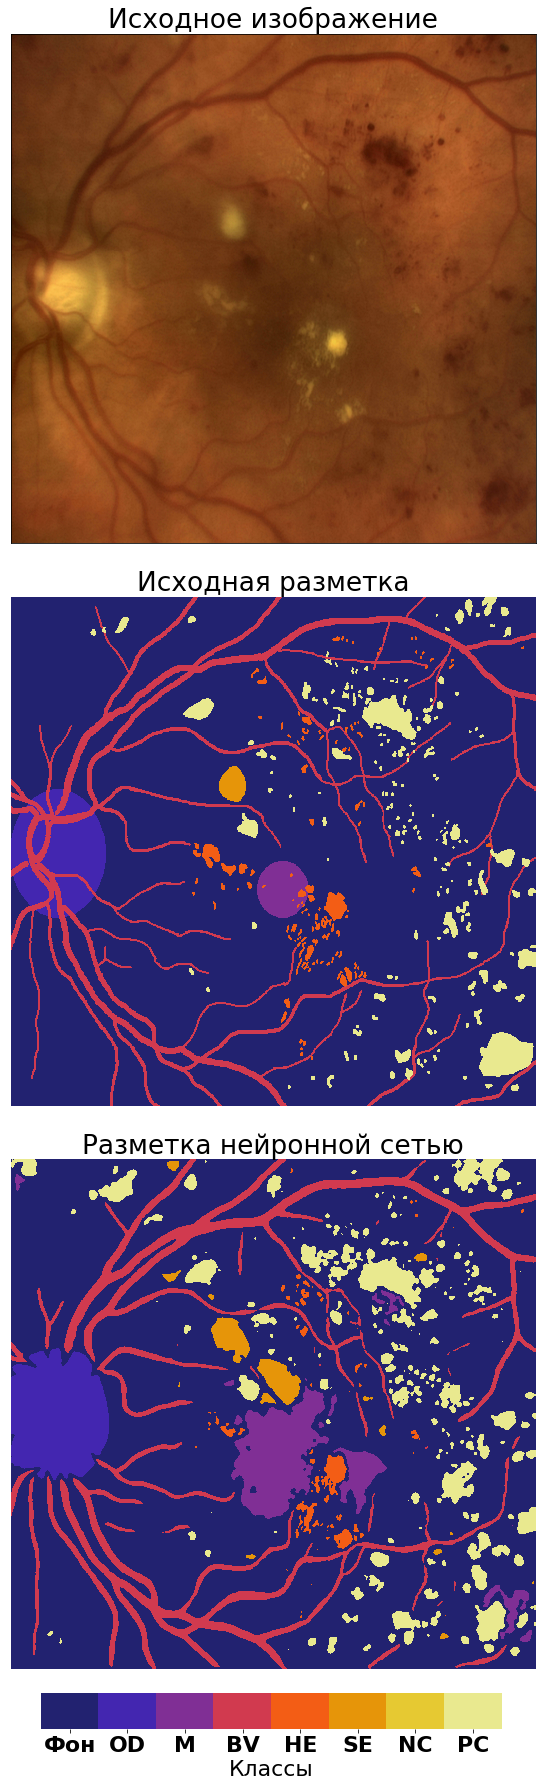

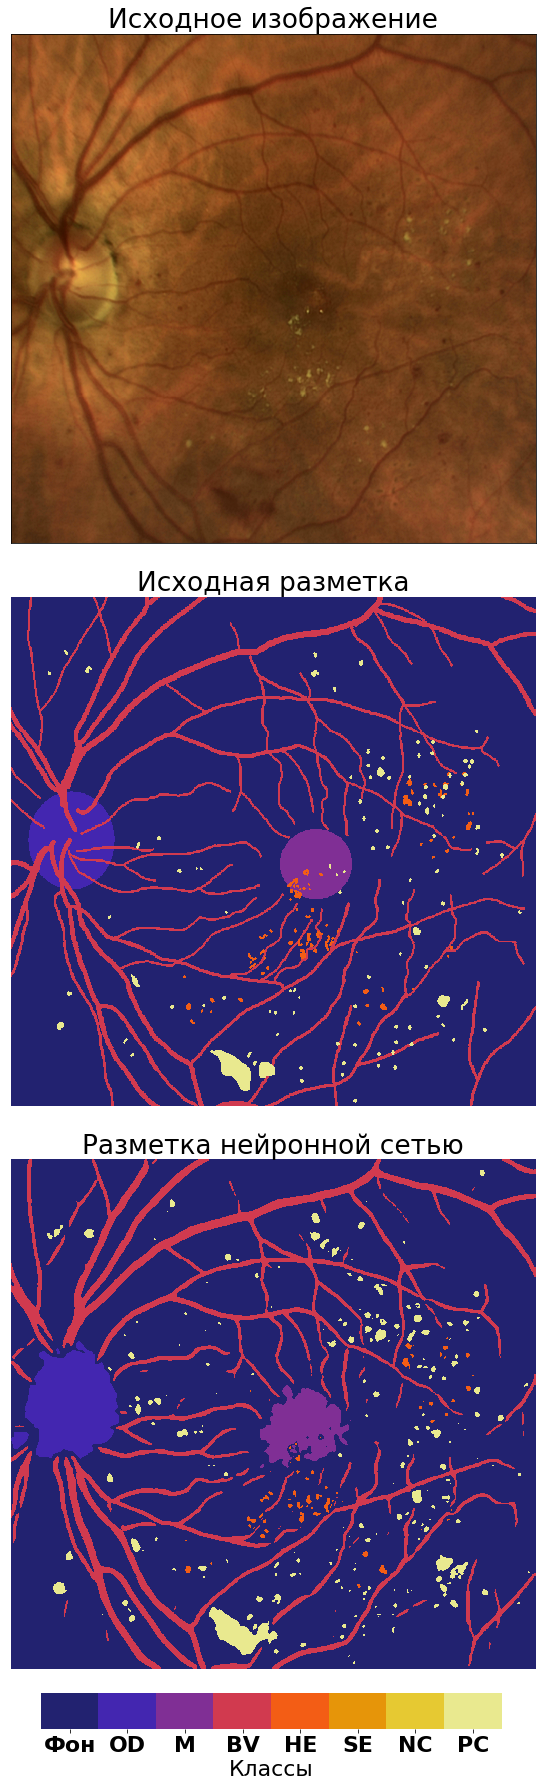

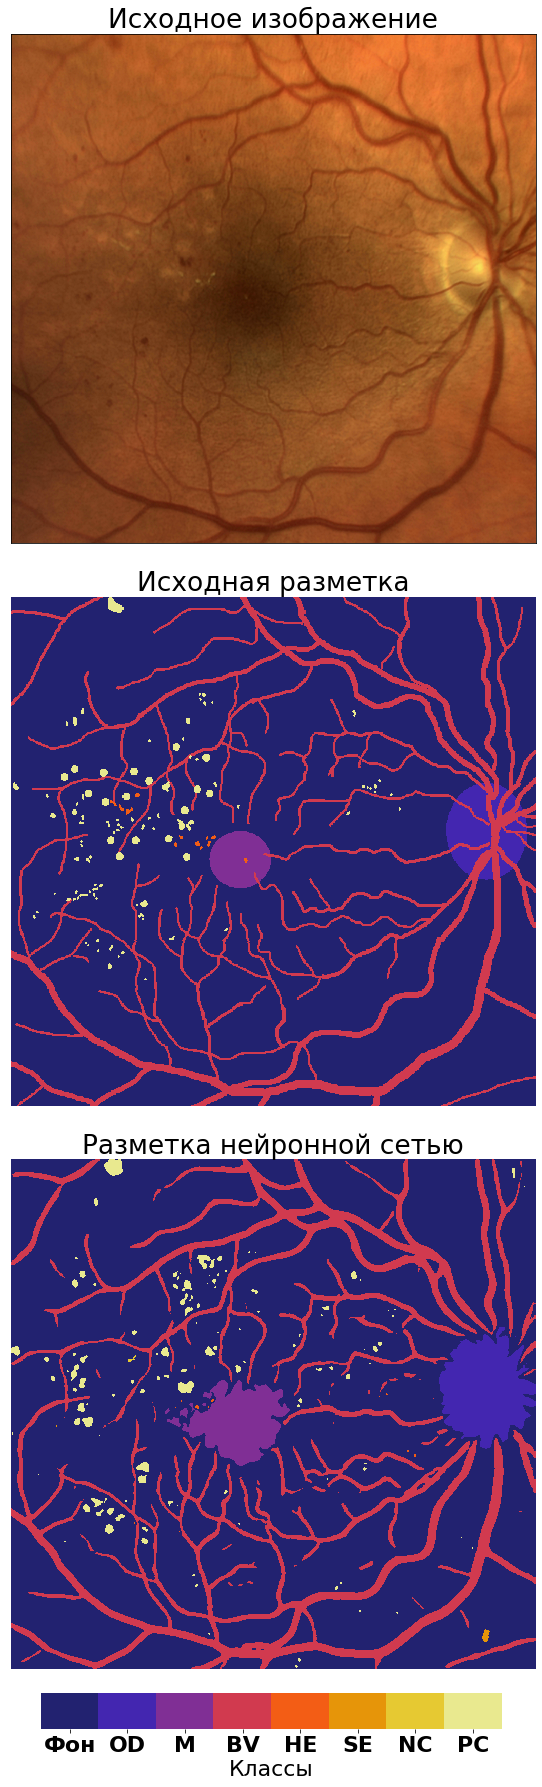

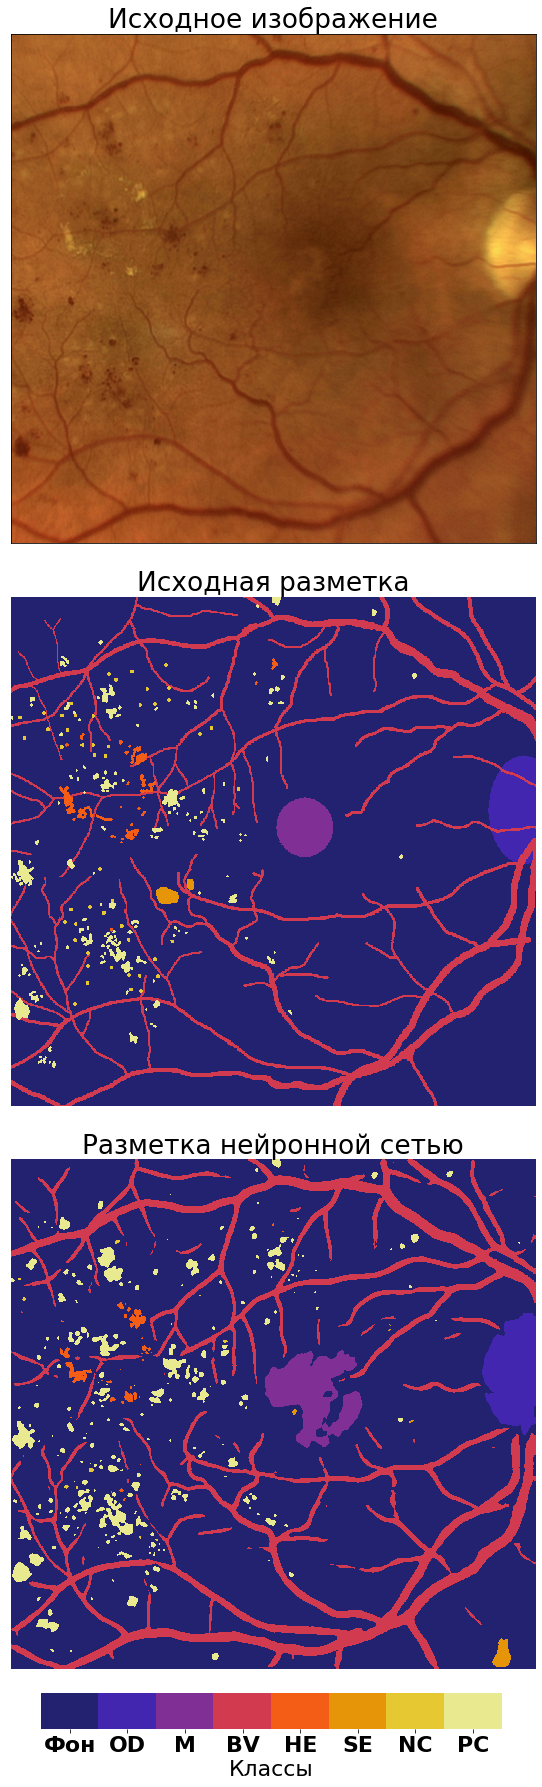

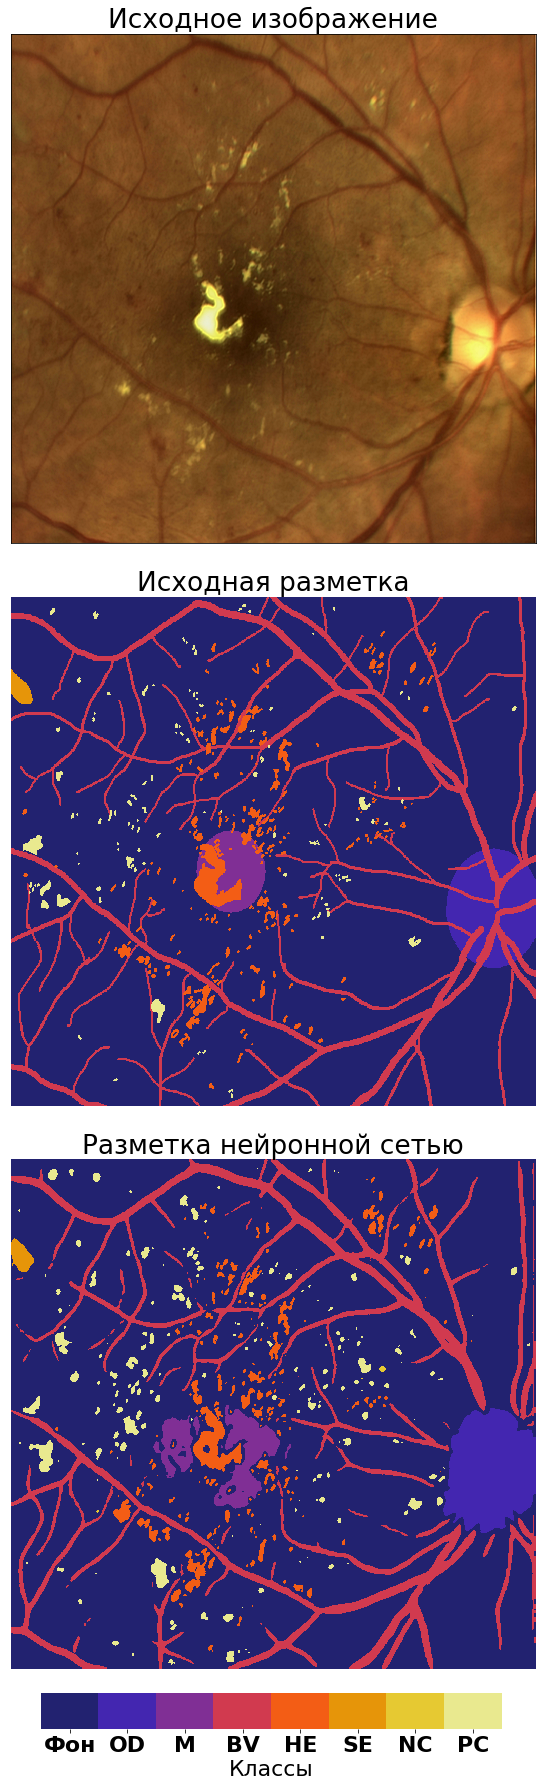

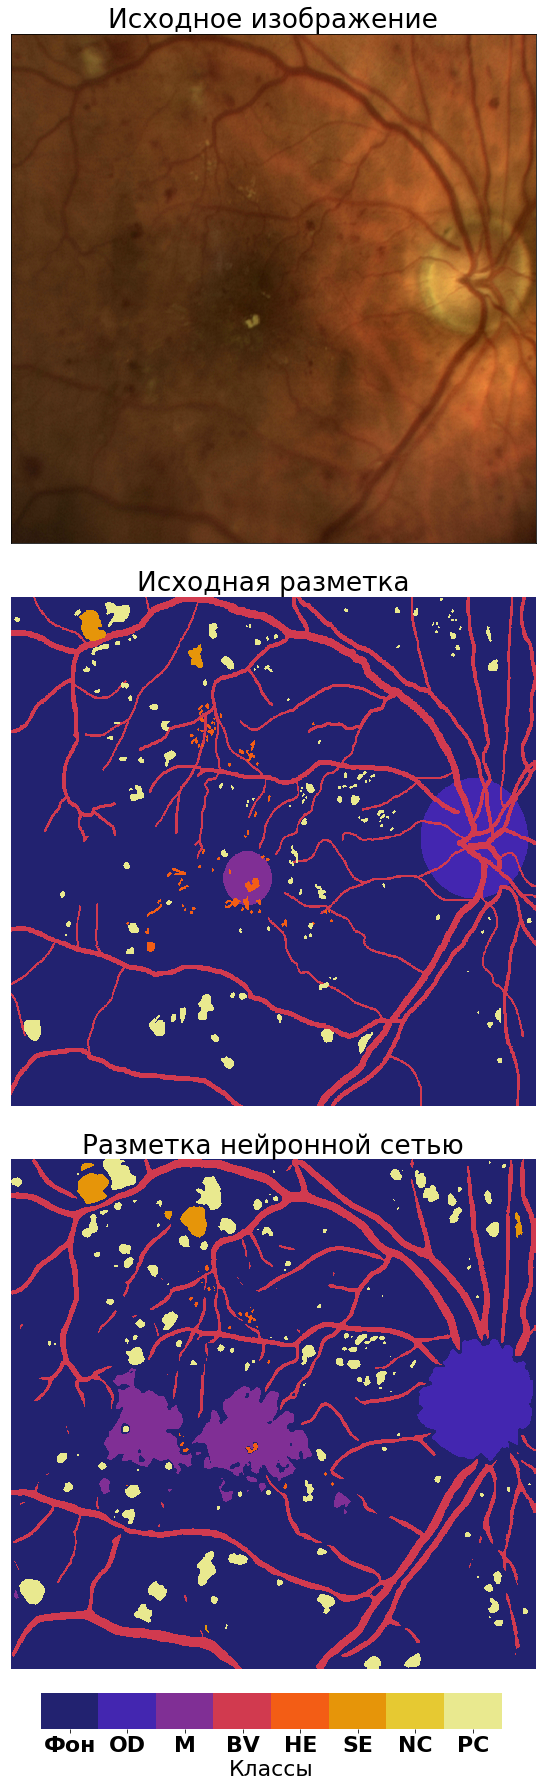

In [354]:
for i in range(8):
    print(f'Plotting {i} image')
    fig, axis = plt.subplots(3, 1, figsize=(8, 25), sharex=True, sharey=True)
    # cbar_ax = fig.add_axes([.91, .3, .03, .4])
    cbar_ax = fig.add_axes([.1, .03, .8, .02])


    ax = sns.heatmap(predictions[i], vmin=0, vmax=8, ax=axis[2], cmap=cmap, cbar=True, cbar_kws={'label': 'Классы', 'orientation': 'horizontal'}, xticklabels=False, yticklabels=False, cbar_ax=cbar_ax)
    sns.heatmap(masks[i], vmin=0, vmax=8, ax=axis[1], cmap=cmap, cbar=False, xticklabels=False, yticklabels=False, cbar_ax=None)
    axis[0].imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
    axis[0].set_aspect('auto')

    axis[2].set_title('Разметка нейронной сетью')
    axis[1].set_title('Исходная разметка')
    axis[0].set_title('Исходное изображение')

    cbar = ax.collections[0].colorbar
    cbar.set_ticks(np.arange(0, 8) + 0.5)
    cbar.set_ticklabels(yticklabels)
    fig.tight_layout(rect=[0, .05, 1, 1])

    fig.savefig(f'figures/{i}.png')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


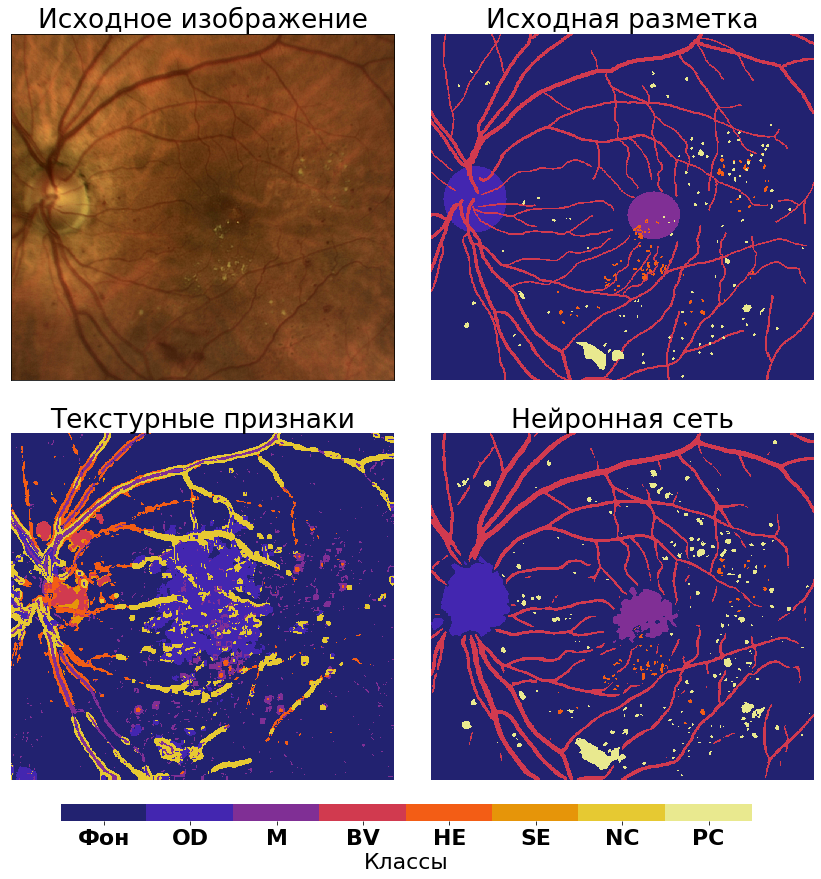

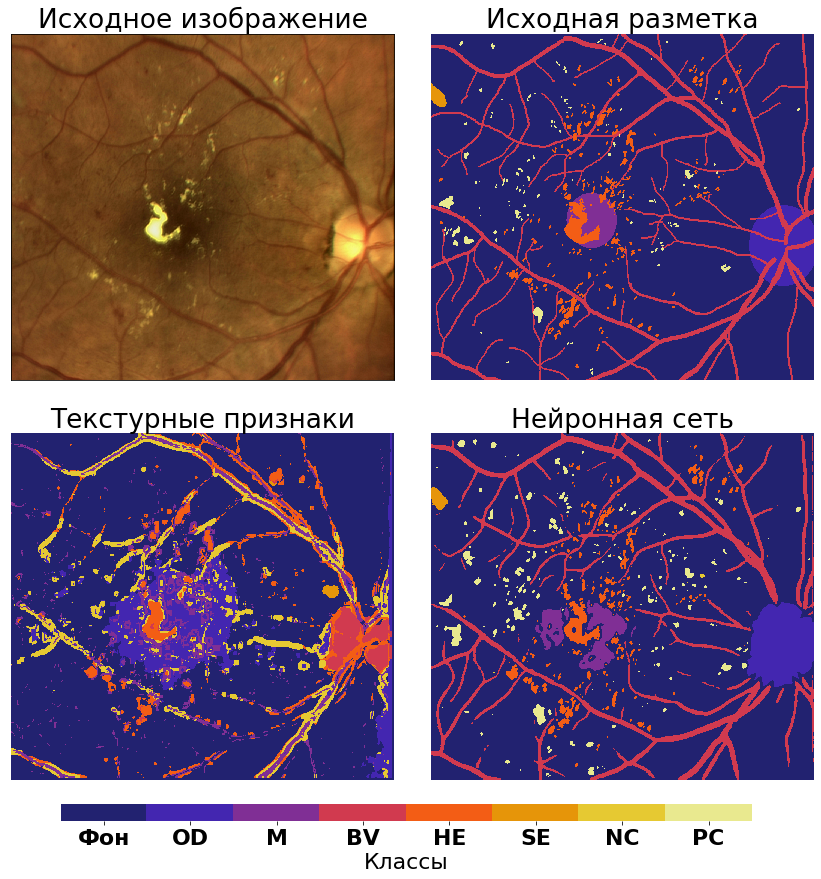

In [361]:
for i in [3, 6]:
    texture_mask = np.load(f'{i}_mask.npy')
    texture_mask = cv2.resize(texture_mask, (1024, 1024), interpolation=cv2.INTER_NEAREST)
    fig, axis = plt.subplots(2, 2, figsize=(12, 12), sharex=True, sharey=True)
    cbar_ax = fig.add_axes([.1, .03, .8, .02])

    ax = sns.heatmap(predictions[i], vmin=0, vmax=8, ax=axis[1, 1], cmap=cmap, cbar=True, cbar_kws={'label': 'Классы', 'orientation': 'horizontal'}, xticklabels=False, yticklabels=False, cbar_ax=cbar_ax)
    sns.heatmap(texture_mask, vmin=0, vmax=8, ax=axis[1, 0], cmap=cmap, cbar=False, xticklabels=False, yticklabels=False, cbar_ax=None)
    axis[0, 0].imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
    axis[0, 0].set_aspect('auto')
    sns.heatmap(masks[i], vmin=0, vmax=8, ax=axis[0, 1], cmap=cmap, cbar=False, xticklabels=False, yticklabels=False, cbar_ax=None)

    axis[1, 0].set_title('Текстурные признаки')
    axis[1, 1].set_title('Нейронная сеть')
    axis[0, 1].set_title('Исходная разметка')
    axis[0, 0].set_title('Исходное изображение')

    cbar = ax.collections[0].colorbar
    cbar.set_ticks(np.arange(0, 8) + 0.5)
    cbar.set_ticklabels(yticklabels)
    fig.tight_layout(rect=[0, .05, 1, 1])

    fig.savefig(f'figures/compare_{i}.png')

True